In [1]:
pwd()
using Pkg; Pkg.activate("../")
Pkg.add("Polynomials")
using FermiCG, NPZ, JLD2, Printf
using Plots
readdir()

  Activating project at `~/code/adiabatic_connection/FermiCG`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
┌ Warning: The active manifest file at `/Users/nmayhall/code/adiabatic_connection/FermiCG/Manifest.toml` has an old format that is being maintained.
│ To update to the new format run `Pkg.upgrade_manifest()` which will upgrade the format without re-resolving.
└ @ Pkg.Types /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.7/Pkg/src/manifest.jl:287
  No Changes to `~/code/adiabatic_connection/FermiCG/Project.toml`
  No Changes to `~/code/adiabatic_connection/FermiCG/Manifest.toml`
┌ Warning: The active manifest file is an older format with no julia version entry. Dependencies may have been resolved with a different julia version.
└ @ nothing /Users/nmayhall/code/adiabatic_connection/FermiCG/Manifest.toml:0
Precompiling project...
  ✓ FermiCG
  1 dependency successfully precompiled in 15 seconds (268 already 

13-element Vector{String}:
 ".ipynb_checkpoints"
 "FixedAdiabaticConnection.ipynb"
 "PAH18-1.ipynb"
 "benzene-10mer.ipynb"
 "cepa.jl"
 "cmf_h6.jl"
 "cr_freedman_def2-svp-2-uhf.ipynb"
 "cr_freedman_def2-svp-2.ipynb"
 "cr_qubit_scf.ipynb"
 "davidson.jl"
 "fci_h6.jl"
 "fe2s2"
 "fe2s2.ipynb"

In [2]:
Pkg.precompile()

# Generate Guess

Generate guess vectors for the first 5 roots.
This is done by just adding the single excitonic states.

In [3]:
# Load data for a square Helium cluster with cc-pvdz (20, orbitals)
@load "../test/_testdata_cmf_he4.jld2"


# Create a Block Sparse Tucker state, targetting 5 roots
v = FermiCG.BSTstate(clusters, FermiCG.FockConfig(init_fspace), cluster_bases, R=5)


# Add single Helium excited states into the initial basis
FermiCG.add_single_excitons!(v, FermiCG.FockConfig(init_fspace), cluster_bases)


# Randomize initial vector coefficients
FermiCG.randomize!(v)
FermiCG.orthonormalize!(v)


# Solve for the 5 lowest roots in the current "excitonic" basis
e_ci, v = FermiCG.ci_solve(v, cluster_ops, clustered_ham);



UnitRange{Int64}[1:1, 1:1, 1:1, 1:1]
TuckerConfig{4}((1:1, 1:1, 1:1, 1:1))
 |== BST CI ========================================================
 Solve CI with # variables:                                77
 Cache Hamiltonian:                                  8.202838 seconds (33.03 M allocations: 1.672 GiB, 7.74% gc time, 99.72% compilation time)
 Iter:   1 SS: 5    E:  -13.64379917   -13.40102550   -13.21867013   -12.94787581   -12.77373441   R: 1.3e+00  1.1e+00  1.3e+00  1.2e+00  1.2e+00   LinDep: 6.7e-16* 
 Iter:   2 SS: 10   E:  -15.17608842   -14.69671030   -14.44195050   -14.35035522   -14.22451989   R: 1.2e+00  8.5e-01  7.7e-01  7.1e-01  5.7e-01   LinDep: 3.3e-16* 
 Iter:   3 SS: 15   E:  -16.39474816   -15.14988335   -14.94235493   -14.71201460   -14.47791028   R: 1.0e+00  5.3e-01  6.6e-01  5.3e-01  4.9e-01   LinDep: 1.6e-15* 
 Iter:   4 SS: 20   E:  -16.82023917   -15.34015473   -15.31670984   -15.02539668   -14.94343746   R: 3.9e-01  2.0e-01  2.5e-01  4.3e-01  3.1e-01   LinDe

# BST Cheap

This is a BST calculation with a loose threshold. This should converge quickly, but not be too accurate. 

In [4]:
 e_cheap, v_cheap = FermiCG.block_sparse_tucker(v, cluster_ops, clustered_ham,
                                            max_iter    = 20,
                                            max_iter_pt = 200,
                                            nbody       = 4,
                                            H0          = "Hcmf",
                                            thresh_var  = 1e-1,
                                            thresh_foi  = 1e-5,
                                            thresh_pt   = 1e-3,
                                            ci_conv     = 1e-5,
                                            do_pt       = true,
                                            resolve_ss  = false,
                                            tol_tucker  = 1e-4);


 max_iter         : 20
 max_iter_pt      : 200
 nbody            : 4
 H0               : Hcmf
 thresh_var       : 0.1
 thresh_foi       : 1.0e-5
 thresh_pt        : 0.001
 ci_conv          : 1.0e-5
 ci_max_iter      : 50
 ci_max_ss_vecs   : 12
 ci_lindep_thresh : 1.0e-10
 resolve_ss       : false
 do_pt            : true
 tol_tucker       : 0.0001



     BST Iteration:    1 epsilon:   0.10000000
 Ref state compressed from:                                77 → 5          (thresh =  1.0e-01)
 Compute zeroth-order energy:                        0.016951 seconds (102.56 k allocations: 6.816 MiB, 72.66% compilation time)
 Compute <S^2>:                                      0.088540 seconds (206.70 k allocations: 12.022 MiB, 98.19% compilation time)
  Root       Energy           S2
     1 -16.88521807   0.00000000
     2 -15.37378501   2.00000000
     3 -15.37105099   2.00000000
     4 -15.37099578   2.00000000
     5 -15.36813769   2.00000000

 Compute FOIS. Reference space dim:            

 Add results together:                               0.821405 seconds (1.48 M allocations: 884.392 MiB, 28.93% gc time, 20.08% compilation time)
 Total time spent building FOIS:                     1.835932 seconds
 FOIS compressed from:                                 232881 → 71887      (thresh =  1.0e-05)
     1 -16.88524912
     2 -15.43032144
     3 -15.41898826
     4 -15.41893102
     5 -15.40710690

 PT vector reference space dim:                            21
 Length of input      FOIS:                             71887
 Build exact <X|V|0>:                                0.376365 seconds (2.63 M allocations: 599.053 MiB, 27.94% gc time, 7.70% compilation time)
 Compute <0|H0|0>:                                   0.001401 seconds (21.57 k allocations: 1.688 MiB)
  Root      <0|H|0>      <0|F|0>
     1 -16.88524912 -11.55001954
     2 -15.43032519  -9.95909750
     3 -15.41898700  -9.97558064
     4 -15.41893208  -9.97516496
     5 -15.40710261  -9.99118532
 Compute <X|F|0>:   

 Time to solve for PT1 with conjugate gradient:      0.581588 seconds
 Time to solve for PT1 with conjugate gradient:      0.411390 seconds
 Time to solve for PT1 with conjugate gradient:      0.379376 seconds
 Time to solve for PT1 with conjugate gradient:      0.178939 seconds
 Time to solve for PT1 with conjugate gradient:      0.366106 seconds
 Compute <0|H|1>:                                    0.393272 seconds (2.74 M allocations: 420.058 MiB, 51.12% gc time)
 State   1: E(PT2) corr:                          -0.00047645
 State   2: E(PT2) corr:                          -0.00012723
 State   3: E(PT2) corr:                          -0.00049462
 State   4: E(PT2) corr:                          -0.00049388
 State   5: E(PT2) corr:                          -0.00081033
 State   1: E(PT2):                              -16.88572519
 State   2: E(PT2):                              -15.43096747
 State   3: E(PT2):                              -15.41987423
 State   4: E(PT2):               

([-16.88614615137514, -15.434619001965732, -15.422064528493346, -15.421775693754157, -15.408894367168081], FermiCG.BSTstate{Float64, 4, 5}(Cluster[Cluster(1, [1, 2, 3, 4, 5]), Cluster(2, [6, 7, 8, 9, 10]), Cluster(3, [11, 12, 13, 14, 15]), Cluster(4, [16, 17, 18, 19, 20])], OrderedCollections.OrderedDict{FockConfig{4}, OrderedCollections.OrderedDict{TuckerConfig{4}, FermiCG.Tucker{Float64, 4, 5}}}(FockConfig{4}(((1, 1), (1, 1), (1, 1), (1, 1))) => OrderedCollections.OrderedDict(TuckerConfig{4}((1:1, 1:1, 1:1, 1:1)) => FermiCG.Tucker{Float64, 4, 5}(([0.999889852845697;;;;], [5.671591013310517e-11;;;;], [-1.2687288888514233e-10;;;;], [-2.9867125648229734e-10;;;;], [-2.251108198286128e-10;;;;]), ([1.0;;], [1.0;;], [1.0;;], [1.0;;])), TuckerConfig{4}((2:20, 1:1, 1:1, 1:1)) => FermiCG.Tucker{Float64, 4, 5}(([2.1954424165868737e-10; -2.048594392094537e-9; -5.855188849817487e-10;;;;], [-0.5346775718688197; -0.0016958681519568164; -6.515194610706488e-10;;;;], [-3.9943853566557035e-6; -2.619521

# Cheap BST+PT2

Add a PT2 correction to the cheap BST calculation above. 

In [5]:
@time e_cheap_pt2 = FermiCG.compute_pt2_energy(v_cheap, cluster_ops, clustered_ham)

 |== Compute PT2 Energy ============================================
 H0          : Hcmf
 max_iter    : 50
 nbody       : 4
 thresh_foi  : 1.0e-6
 max_number  : nothing
 tol         : 1.0e-5
 opt_ref     : true
 verbose     : true

 Length of Reference:                                     242
 Solve zeroth-order problem:                       
 |== BST CI ========================================================
 Solve CI with # variables:                               242
 Cache Hamiltonian:                                  0.149856 seconds (1.87 M allocations: 180.908 MiB)
 Iter:   1 SS: 5    E:  -16.88614615*  -15.43461900*  -15.42206453*  -15.42177569*  -15.40889437*  R: 6.2e-06* 3.3e-06* 7.4e-06* 1.8e-06* 4.1e-06*  LinDep: 6.7e-16* 
 Diagonalization time:                               0.214769 seconds
 Compute <S^2>:                                      0.025412 seconds (402.66 k allocations: 26.644 MiB)
  Root       Energy           S2
     1 -16.88614615   0.00000375
     2 -15.4

5-element Vector{Float64}:
 -3.998585684072964e-5
 -0.0002303605374542883
 -0.00022162507083223204
 -0.00021961686297267136
 -0.00018357449168426854

# Fixed basis AC

Instead of solving for an adaptive basis at only small values of lambda, perhaps we can fix the basis, then solve for different lambda values in that same basis. We could then solve for approximate basis at λ=1, and then scan backword in the same basis, or we could solve accurate basis for λ=.1 (for example) and then scan forward to λ=1, fixing the basis. The question, will then be if the integral of the path is more accurate than the final point. 

In [55]:
# Define a grid of lambda values
lambda_grid = [collect(0:10)...]/10.0
@time lvec, evec, dvec, dims, times = FermiCG.compute_ac_fixed(v_cheap, cluster_ops, clustered_ham, lambda_grid)


 λ =   0.00000000
 Remove duplicates
 Number of terms reduced from   476 to   476
 |== BST CI ========================================================
 Solve CI with # variables:                               242
 Cache Hamiltonian:                                  0.184882 seconds (1.75 M allocations: 144.343 MiB, 11.27% gc time)
 Iter:   1 SS: 5    E:  -11.54909169    -9.98764959    -9.97015637    -9.96885192    -9.95074534   R: 6.7e-02  2.1e-01  2.4e-01  2.4e-01  2.6e-01   LinDep: 6.7e-16* 
 Iter:   2 SS: 10   E:  -11.55003713   -10.02632441   -10.02291395   -10.02254468   -10.01896320   R: 1.0e-02  1.7e-01  1.8e-01  1.8e-01  1.9e-01   LinDep: 4.4e-16* 
 Iter:   3 SS: 15   E:  -11.55006119   -10.03627563   -10.03340925   -10.03336472   -10.03039659   R: 3.1e-03  7.4e-02  7.7e-02  7.8e-02  8.2e-02   LinDep: 4.4e-16* 
 Iter:   4 SS: 20   E:  -11.55006451   -10.03820554   -10.03556621   -10.03556448   -10.03282289   R: 6.0e-04  3.1e-02  3.2e-02  3.2e-02  3.2e-02   LinDep: 2.2e-15* 
 It

 Iter:  12 SS: 55   E:  -12.61713104*  -11.10700814*  -11.10447802   -11.10447422   -11.10183411*  R: 5.2e-07* 6.3e-07* 1.5e-06  1.7e-06  6.0e-07*  LinDep: 2.6e-15* 
 Iter:  13 SS: 57   E:  -12.61713104*  -11.10700814*  -11.10447802*  -11.10447422*  -11.10183411*  R: 5.2e-07* 6.0e-07* 3.4e-07* 4.0e-07* 5.8e-07*  LinDep: 1.8e-15* 
 Diagonalization time:                               2.760256 seconds
 Compute <S^2>:                                      0.052319 seconds (402.46 k allocations: 26.624 MiB, 56.69% gc time)
  Root       Energy           S2
     1 -12.61713104   0.00000013
     2 -11.10700814   2.00000000
     3 -11.10447802   2.00000000
     4 -11.10447422   2.00000000
     5 -11.10183411   2.00000000
 ==================================================================|
 λ =   0.30000000
 Remove duplicates
 Number of terms reduced from   476 to   476
 |== BST CI ========================================================
 Solve CI with # variables:                               2

 Iter:   7 SS: 35   E:  -14.21786791   -12.71737852   -12.71453225   -12.71436528   -12.71101927   R: 1.2e-06  4.9e-04  4.9e-04  4.9e-04  4.6e-04   LinDep: 2.0e-15* 
 Iter:   8 SS: 40   E:  -14.21786791*  -12.71737861   -12.71453234   -12.71436537   -12.71101936   R: 4.3e-07* 8.7e-05  8.6e-05  8.8e-05  8.1e-05   LinDep: 3.8e-15* 
 Iter:   9 SS: 44   E:  -14.21786791*  -12.71737862   -12.71453235   -12.71436538   -12.71101936   R: 4.3e-07* 3.3e-05  3.8e-05  3.8e-05  3.3e-05   LinDep: 4.4e-16* 
 Iter:  10 SS: 48   E:  -14.21786791*  -12.71737862   -12.71453235   -12.71436538   -12.71101936   R: 4.3e-07* 1.8e-05  2.5e-05  2.1e-05  2.0e-05   LinDep: 1.3e-15* 
 Iter:  11 SS: 52   E:  -14.21786791*  -12.71737862   -12.71453235   -12.71436538   -12.71101936   R: 4.3e-07* 1.0e-05  1.5e-05  8.6e-06  1.3e-05   LinDep: 6.7e-15* 
 Iter:  12 SS: 56   E:  -14.21786791*  -12.71737862   -12.71453235   -12.71436538   -12.71101936   R: 4.3e-07* 2.4e-06  3.8e-06  3.7e-06  2.8e-06   LinDep: 6.8e-15* 
 Ite

 Iter:  16 SS: 11   E:  -15.28512032*  -13.79870133*  -13.79335489   -13.79324438   -13.78735277*  R: 3.2e-07* 3.4e-07* 1.1e-06  1.3e-06  4.7e-07*  LinDep: 2.6e-15* 
 Iter:  17 SS: 13   E:  -15.28512032*  -13.79870133*  -13.79335489*  -13.79324438*  -13.78735277*  R: 3.0e-07* 3.3e-07* 6.0e-07* 6.1e-07* 4.0e-07*  LinDep: 2.6e-15* 
 Diagonalization time:                               2.971339 seconds
 Compute <S^2>:                                      0.023177 seconds (401.50 k allocations: 26.262 MiB)
  Root       Energy           S2
     1 -15.28512032   0.00000175
     2 -13.79870133   2.00000000
     3 -13.79335489   2.00000000
     4 -13.79324438   2.00000000
     5 -13.78735277   2.00000000
 ==================================================================|
 λ =   0.80000000
 Remove duplicates
 Number of terms reduced from   476 to   476
 |== BST CI ========================================================
 Solve CI with # variables:                               242
 Cache Hamilt

 Cache Hamiltonian:                                  0.188845 seconds (1.75 M allocations: 146.404 MiB, 10.12% gc time)
 Iter:   1 SS: 5    E:  -16.88613605   -15.43361873   -15.42125175   -15.42097448   -15.40829173   R: 6.7e-03  2.6e-02  2.4e-02  2.3e-02  2.1e-02   LinDep: 1.1e-16* 
 Iter:   2 SS: 10   E:  -16.88614578   -15.43434520   -15.42182425   -15.42153703   -15.40869664   R: 1.2e-03  2.4e-02  2.2e-02  2.1e-02  1.8e-02   LinDep: 4.4e-16* 
 Iter:   3 SS: 15   E:  -16.88614610   -15.43453718   -15.42199141   -15.42170343   -15.40882822   R: 3.6e-04  1.2e-02  1.1e-02  1.1e-02  1.1e-02   LinDep: 2.1e-15* 
 Iter:   4 SS: 20   E:  -16.88614615   -15.43459748   -15.42204633   -15.42175741   -15.40887858   R: 6.7e-05  7.0e-03  6.5e-03  6.5e-03  6.2e-03   LinDep: 2.4e-15* 
 Iter:   5 SS: 25   E:  -16.88614615   -15.43461255   -15.42205931   -15.42177047   -15.40889040   R: 1.9e-05  2.9e-03  2.6e-03  2.6e-03  2.3e-03   LinDep: 3.4e-15* 
 Iter:   6 SS: 30   E:  -16.88614615   -15.4346176

([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [-16.887119048338665 -15.375519659112387 … -15.37288852131804 -15.370155045676725; -16.886937849094334 -15.375695290389324 … -15.373090240109732 -15.370382859246693; … ; -16.886156305835584 -15.421049346792165 … -15.411149821851371 -15.40098953975431; -16.886146151383915 -15.434619001968326 … -15.421775693754977 -15.408894367172195], [0.0019009810677701466 0.0019009807952254931 … 0.0019005081990233208 0.00190098096636504; 0.0017226016137019684 -0.005513491676806481 … -0.0060387737444251854 -0.006560748694036889; … ; 0.00020259592898952405 -0.12553302328065818 … -0.09824508513937502 -0.07318411063185692; -7.596668183396105e-9 -0.1460127928104349 … -0.11446031146936164 -0.0851012766782624], [242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242], [2.91292032, 3.094217258, 2.997423933, 3.226477918, 3.194584251, 3.250099132, 3.206643442, 3.553447491, 3.551682768, 3.550529242, 3.337818727])

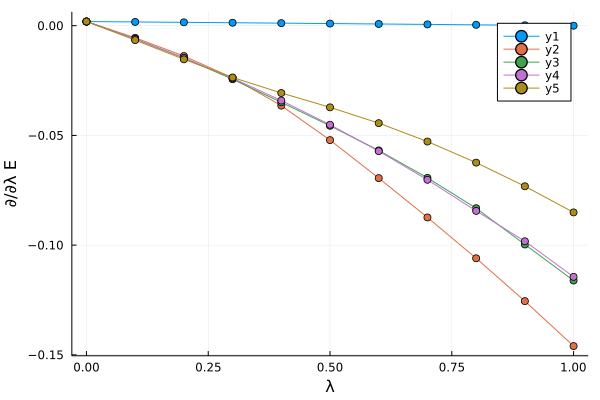

In [60]:
p1 = plot(lvec, dvec, markershape=:circle)
plot!(p1, xaxis="λ")
plot!(p1, yaxis="∂/∂λ E")

In [57]:
function integrate(dvec,lvec)
    e = zeros(size(dvec,2))
    n_points = length(lvec)
    for li in 2:n_points
        e += (dvec[li-1,:]+dvec[li,:])*(lvec[li]-lvec[li-1])/2
    end
    return e
end
dE_ac = integrate(dvec, lvec)
for (i,ei) in enumerate(dE_ac)
    @printf(" State: %4i E(0): %12.8f E(1): %12.8f E(ac): %12.8f dE: %12.8f\n", i,evec[1,i],evec[end,i], evec[1,i]+ei,ei)
end


 State:    1 E(0): -16.88711905 E(1): -16.88614615 E(ac): -16.88614638 dE:   0.00097267
 State:    2 E(0): -15.37551966 E(1): -15.43461900 E(ac): -15.43473385 dE:  -0.05921419
 State:    3 E(0): -15.37288959 E(1): -15.42206453 E(ac): -15.42208391 dE:  -0.04919432
 State:    4 E(0): -15.37288852 E(1): -15.42177569 E(ac): -15.42191039 dE:  -0.04902187
 State:    5 E(0): -15.37015505 E(1): -15.40889437 E(ac): -15.40893076 dE:  -0.03877572


# Exact solution

In [9]:
 e_exact, v_exact = FermiCG.block_sparse_tucker(v, cluster_ops, clustered_ham,
                                            max_iter    = 20,
                                            max_iter_pt = 200,
                                            nbody       = 4,
                                            H0          = "Hcmf",
                                            thresh_var  = 1e-3,
                                            thresh_foi  = 1e-6,
                                            thresh_pt   = 1e-5,
                                            ci_conv     = 1e-5,
                                            do_pt       = true,
                                            resolve_ss  = false,
                                            tol_tucker  = 1e-4);


 max_iter         : 20
 max_iter_pt      : 200
 nbody            : 4
 H0               : Hcmf
 thresh_var       : 0.001
 thresh_foi       : 1.0e-6
 thresh_pt        : 1.0e-5
 ci_conv          : 1.0e-5
 ci_max_iter      : 50
 ci_max_ss_vecs   : 12
 ci_lindep_thresh : 1.0e-10
 resolve_ss       : false
 do_pt            : true
 tol_tucker       : 0.0001



     BST Iteration:    1 epsilon:   0.00100000
 Ref state compressed from:                                77 → 5          (thresh =  1.0e-03)
 Compute zeroth-order energy:                        0.004866 seconds (85.92 k allocations: 5.906 MiB)
 Compute <S^2>:                                      0.001647 seconds (25.06 k allocations: 1.938 MiB)
  Root       Energy           S2
     1 -16.88521807   0.00000000
     2 -15.37378501   2.00000000
     3 -15.37105099   2.00000000
     4 -15.37099578   2.00000000
     5 -15.36813769   2.00000000

 Compute FOIS. Reference space dim:                         5
 Number of tasks:                  

 Compute <S^2>:                                      0.347633 seconds (1.17 M allocations: 146.090 MiB, 82.85% gc time)
 E(Reference):       -16.88521807 -15.37378501 -15.37105099 -15.37099578 -15.36813769 
 E(PT2):             -16.88386905 -15.38644425 -15.38526332 -15.38552953 -15.38493283 
 E(BST):             -16.88619232 -15.43548411 -15.42275879 -15.42250665 -15.40939201 




     BST Iteration:    2 epsilon:   0.00100000
 Ref state compressed from:                              8293 → 734        (thresh =  1.0e-03)
 Compute zeroth-order energy:                        0.627077 seconds (8.90 M allocations: 623.991 MiB, 21.51% gc time)
 Compute <S^2>:                                      0.168213 seconds (596.15 k allocations: 42.881 MiB, 81.81% gc time)
  Root       Energy           S2
     1 -16.88616140   0.00000161
     2 -15.43542677   2.00000000
     3 -15.42269712   2.00000000
     4 -15.42244571   2.00000000
     5 -15.40933431   2.00000000

 Compute FOIS. Reference space di

 Iter:  24 SS: 45   E:  -16.88619532*  -15.43619163*  -15.42327394   -15.42303014   -15.40974286   R: 5.8e-06* 9.7e-06* 2.2e-05  2.2e-05  1.3e-05   LinDep: 3.9e-15* 
 Iter:  25 SS: 48   E:  -16.88619532*  -15.43619163*  -15.42327394   -15.42303014   -15.40974286*  R: 5.8e-06* 9.6e-06* 1.2e-05  1.2e-05  7.9e-06*  LinDep: 1.0e-15* 
 Iter:  26 SS: 50   E:  -16.88619532*  -15.43619163*  -15.42327394*  -15.42303014*  -15.40974286*  R: 5.8e-06* 9.5e-06* 7.8e-06* 8.1e-06* 7.9e-06*  LinDep: 6.6e-15* 
 Diagonalization time:                              60.511610 seconds
 Compute <S^2>:                                      0.093419 seconds (1.21 M allocations: 294.870 MiB, 24.72% gc time)
  Root       Energy           S2
     1 -16.88619532   0.00000050
     2 -15.43619163   2.00000020
     3 -15.42327394   2.00000009
     4 -15.42303014   2.00000009
     5 -15.40974286   2.00000023
 ==================================================================|
 Compute <S^2>:                              

 Iter:  19 SS: 25   E:  -16.88619532*  -15.43619559   -15.42327841   -15.42303330   -15.40974578   R: 5.7e-06* 2.9e-05  9.5e-05  9.7e-05  3.2e-05   LinDep: 3.6e-15* 
 Iter:  20 SS: 29   E:  -16.88619532*  -15.43619559   -15.42327841   -15.42303330   -15.40974578   R: 5.7e-06* 1.6e-05  6.6e-05  6.8e-05  1.7e-05   LinDep: 8.9e-15* 
 Iter:  21 SS: 33   E:  -16.88619532*  -15.43619559*  -15.42327841   -15.42303331   -15.40974578   R: 5.7e-06* 9.3e-06* 4.9e-05  5.0e-05  1.0e-05   LinDep: 8.9e-15* 
 Iter:  22 SS: 35   E:  -16.88619532*  -15.43619559*  -15.42327841   -15.42303331   -15.40974578*  R: 5.7e-06* 8.2e-06* 3.2e-05  3.4e-05  9.9e-06*  LinDep: 2.8e-15* 
 Iter:  23 SS: 37   E:  -16.88619532*  -15.43619559*  -15.42327841   -15.42303331   -15.40974578*  R: 5.7e-06* 7.5e-06* 2.0e-05  2.1e-05  9.7e-06*  LinDep: 6.3e-15* 
 Iter:  24 SS: 39   E:  -16.88619532*  -15.43619559*  -15.42327841   -15.42303331   -15.40974578*  R: 5.7e-06* 7.3e-06* 1.1e-05  1.1e-05  9.7e-06*  LinDep: 1.1e-14* 
 Ite

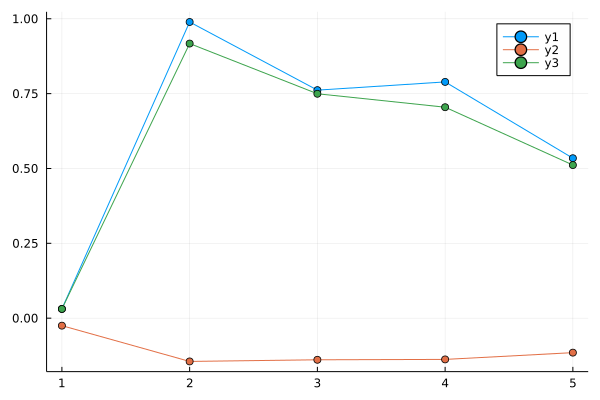

In [59]:
err_cheap = e_cheap - e_exact
err_cheap_pt2 = e_cheap_pt2 - e_exact
err_ac = evec[1,:]+dE_ac - e_exact
plot([err_cheap, e_cheap_pt2, err_ac]*627.51, markershape=:circle)